In [60]:
import os 
import boto3 
from sagemaker import Session  
from sagemaker import get_execution_role 

#Import libraries to handle data prep and feature engineering
import pandas as pd 
import numpy as np 
from sklearn.model_selection import train_test_split 
from sklearn import preprocessing
from matplotlib import pyplot as plt

#import libariries to train model in Sagemaker
from sagemaker.s3 import S3Uploader 
from sagemaker.inputs import TrainingInput 
from sagemaker.image_uris import retrieve 
from sagemaker.estimator import Estimator 

#import libraries for bias and explainability
from sagemaker import clarify 

In [61]:
# Get the session, region and role
session = Session() 
region = session.boto_region_name 
role = get_execution_role() 
s3_client = boto3.client("s3") 

# Set up prefix for data and outputs
bucket = "responsibleai"
data_prefix = "data"
bias_prefix = "bias_explain" 
input_data_path = "s3://{}/{}".format(bucket, data_prefix)
explainability_output_path = "s3://{}/{}/clarify-explainability".format(bucket, bias_prefix) 
bias_report_output_path = "s3://{}/{}/clarify-bias".format(bucket, bias_prefix) 

print("Input data path = " + input_data_path)
print("Bias report path = " + bias_report_output_path)
print("Explainability report path = " + explainability_output_path)

Input data path = s3://responsibleai/data
Bias report path = s3://responsibleai/bias_explain/clarify-bias
Explainability report path = s3://responsibleai/bias_explain/clarify-explainability


### Data Preparation & Feature Engineering

In [62]:
# Load Data set
training_data = pd.read_csv("../data/churn.csv").dropna() 
training_data.head() 

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [63]:
training_data.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [64]:
training_data.columns

Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')

In [65]:
training_data['Gender'].value_counts()

Male      5457
Female    4543
Name: Gender, dtype: int64

(array([4543.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        5457.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

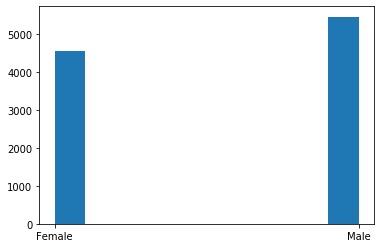

In [66]:
plt.hist(training_data['Gender'])

In [67]:
def number_encode_features(df): 
    result = df.copy() 
    encoders = {} 

    for column in result.columns: 
        if result.dtypes[column] == np.object: 
            encoders[column] = preprocessing.LabelEncoder() 
            result[column] = encoders[column].fit_transform(result[column].fillna("None")) 
    return result, encoders

In [68]:
churn_train, churn_test = train_test_split (training_data, test_size=0.2)

churn_train = pd.concat([churn_train["Exited"], churn_train.drop(["Exited"], axis=1)], axis=1)
churn_train, _ = number_encode_features(churn_train)
churn_train.to_csv("../data/train_churn.csv", index=False, header=False)

churn_test, _ = number_encode_features(churn_test)
churn_features = churn_test.drop(["Exited"], axis=1)
churn_target = churn_test["Exited"]
churn_features.to_csv("../data/test_churn.csv", index=False, header=False)

train_uri = S3Uploader.upload("../data/train_churn.csv", "s3://{}/{}".format(bucket, data_prefix)) 
test_uri = S3Uploader.upload("../data/test_churn.csv", "s3://{}/{}".format(bucket, data_prefix)) 

train_input = TrainingInput(train_uri, content_type="csv") 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


### Model Training

In [69]:
container = retrieve("xgboost", region, version="1.2-1") 

xgb = Estimator(container,
                role, 
                instance_count=1,
                instance_type="ml.m5.xlarge", 
                disable_profiler=True,
                sagemaker_session=session,
                output_path='s3://{}/output'.format(bucket))

xgb.set_hyperparameters(max_depth=5, 
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        objective="binary:logistic",
                        num_round=800,) 

xgb.fit({"train": train_input}, logs=False) 


2022-02-24 18:16:36 Starting - Starting the training job....
2022-02-24 18:16:57 Starting - Preparing the instances for training.............
2022-02-24 18:18:10 Downloading - Downloading input data....
2022-02-24 18:18:36 Training - Downloading the training image..........
2022-02-24 18:19:32 Training - Training image download completed. Training in progress....
2022-02-24 18:19:52 Uploading - Uploading generated training model.
2022-02-24 18:19:58 Completed - Training job completed


In [70]:
model_name = "churn-clarify-model" 
model = xgb.create_model(name=model_name) 
container_def = model.prepare_container_def() 
session.create_model(model_name, role, container_def) 

Using already existing model: churn-clarify-model


'churn-clarify-model'

### Data Bias

In [71]:
clarify_processor = clarify.SageMakerClarifyProcessor( 
                        role=role, 
                        instance_count=1, 
                        instance_type="ml.m5.xlarge", 
                        sagemaker_session=session) 

In [72]:
bias_data_config = clarify.DataConfig( 
    s3_data_input_path=train_uri, 
    s3_output_path=bias_report_output_path, 
    label="Exited", 
    headers=churn_train.columns.to_list(), 
    dataset_type="text/csv") 

model_config = clarify.ModelConfig( 
    model_name=model_name, 
    instance_type="ml.m5.xlarge", 
    instance_count=1,
    accept_type="text/csv", 
    content_type="text/csv",) 

predictions_config = clarify.ModelPredictedLabelConfig(probability_threshold=0.8)

bias_config = clarify.BiasConfig( 
    label_values_or_threshold=[1], 
    facet_name="Gender", 
    facet_values_or_threshold=[0]) 


In [73]:
clarify_processor.run_bias( 
    data_config=bias_data_config, 
    bias_config=bias_config, 
    model_config=model_config, 
    model_predicted_label_config=predictions_config, 
    pre_training_methods="all", 
    post_training_methods="all") 


Job Name:  Clarify-Bias-2022-02-24-18-21-09-506
Inputs:  [{'InputName': 'dataset', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://responsibleai/data/train_churn.csv', 'LocalPath': '/opt/ml/processing/input/data', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'analysis_config', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://responsibleai/bias_explain/clarify-bias/analysis_config.json', 'LocalPath': '/opt/ml/processing/input/config', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'analysis_result', 'AppManaged': False, 'S3Output': {'S3Uri': 's3://responsibleai/bias_explain/clarify-bias', 'LocalPath': '/opt/ml/processing/output', 'S3UploadMode': 'EndOfJob'}}]
.............................INFO:sagemaker-clarify-processing:Starting SageMaker Clarify Processing job
INFO:analyzer.data_loading.dat

In [81]:
from IPython.display import HTML
from IPython.display import IFrame

!aws s3 cp s3://responsibleai/bias_explain/clarify-bias/report.html ../reports/bias_report.html --recursive



In [82]:

IFrame("../reports/bias_report.html", width=600, height=300)

### Model Explainability

In [76]:
shap_config = clarify.SHAPConfig( 
    baseline=[churn_features.iloc[0].values.tolist()], 
    num_samples=15, 
    agg_method="mean_abs", 
    save_local_shap_values=True,) 

explainability_data_config = clarify.DataConfig( 
    s3_data_input_path=train_uri, 
    s3_output_path=explainability_output_path, 
    label="Exited", 
    headers=churn_train.columns.to_list(), 
    dataset_type="text/csv") 

In [77]:
clarify_processor.run_explainability( 
    data_config=explainability_data_config, 
    model_config=model_config, 
    explainability_config=shap_config,) 


Job Name:  Clarify-Explainability-2022-02-24-18-40-18-753
Inputs:  [{'InputName': 'dataset', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://responsibleai/data/train_churn.csv', 'LocalPath': '/opt/ml/processing/input/data', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'analysis_config', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://responsibleai/bias_explain/clarify-explainability/analysis_config.json', 'LocalPath': '/opt/ml/processing/input/config', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'analysis_result', 'AppManaged': False, 'S3Output': {'S3Uri': 's3://responsibleai/bias_explain/clarify-explainability', 'LocalPath': '/opt/ml/processing/output', 'S3UploadMode': 'EndOfJob'}}]
...............................INFO:sagemaker-clarify-processing:Starting SageMaker Clarify Processing jo